In [ ]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns

## Data Loading

Buat struktur folder dataset sebagai berikut:
```
.
└──dataset
    ├── label1
	├── image1.jpg
	├── image2.jpg
	└── image3.jpg
    ├── label2
    └── label3
    └── dst...
```

Kode ini berfungsi untuk membaca gambar dari folder dataset, mengubah ukurannya menjadi 224x224 piksel, mengkonversinya ke grayscale, lalu menyimpan gambar tersebut ke dalam list `data`. Selain itu, kode juga menyimpan label folder dari masing-masing gambar ke list `labels` dan nama file gambar ke list `file_name`. Setelah seluruh gambar diproses, data dan label tersebut diubah menjadi array NumPy untuk memudahkan pengolahan selanjutnya.

In [34]:
data = []
labels = []
file_name = []

for sub_folder in os.listdir("dataset\\"):
    sub_folder_files = os.listdir(os.path.join("dataset\\", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("dataset\\", sub_folder, filename)
        img = cv.imread(img_path)
        img = cv.resize(img, (224, 224))
        img = img.astype(np.uint8)
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        
        data.append(img)
        labels.append(sub_folder)
        name = os.path.splitext(filename)[0]
        file_name.append(filename)
        
data = np.array(data)
labels = np.array(labels)

## Data Augmentation

### Define Augmentation Function


Kode ini berfungsi sebagai kerangka untuk melakukan augmentasi data gambar. Variabel `data_augmented`, `labels_augmented`, `paths_augmented`, dan `file_name_augmented` disiapkan untuk menyimpan hasil augmentasi gambar, labelnya, path, dan nama file yang sudah diaugmentasi. Variabel `angles` berisi sudut rotasi yang bisa digunakan untuk augmentasi (0°, 45°, 90°, 135°). Namun, bagian inti untuk memproses augmentasi dalam loop `for` masih kosong (dengan `pass`), sehingga belum melakukan perubahan apa pun pada data asli. Setelah itu, list hasil augmentasi akan diubah menjadi array NumPy agar mudah digunakan untuk pemrosesan selanjutnya.

In [35]:
# melakukan augmentasi data
data_augmented = []
labels_augmented = []
paths_augmented = []
file_name_augmented = []
angles = [0, 45, 90, 135]

for i in range(len(data)):
    pass

data_augmented = np.array(data_augmented)
labels_augmented = np.array(labels_augmented)

Kode ini berfungsi untuk menampilkan jumlah data gambar sebelum dan sesudah proses augmentasi. Baris pertama mencetak banyaknya data asli yang belum diaugmentasi, sedangkan baris kedua mencetak banyaknya data yang sudah melewati proses augmentasi, sehingga bisa digunakan untuk membandingkan dan memastikan bahwa augmentasi telah dilakukan (jika ada).

In [36]:
print("Data sebelum augmentasi: ", len(data))
print("Data setelah augmentasi: ", len(data_augmented))

Data sebelum augmentasi:  200
Data setelah augmentasi:  0


## Data Preparation

### Define Preprocessing Function


1. **Equalize Histogram** (`equalize_histogram`):

   * Meningkatkan kontras gambar dengan meratakan distribusi intensitas piksel.
   * Fungsi `histogram` menghitung frekuensi kemunculan intensitas piksel.
   * `equalize_histogram` menggunakan histogram untuk menghitung distribusi kumulatif dan memetakan ulang nilai piksel.

2. **Sharpening** (`convolution` dengan kernel sharpening):

   * Memperjelas tepi dan detail pada gambar dengan konvolusi menggunakan kernel sharpen.
   * Kernel `[[0, -1, 0], [-1, 5, -1], [0, -1, 0]]` menonjolkan perubahan intensitas.

3. **Median Filter** (`medianfilter`):

   * Mengurangi noise dengan cara mengganti nilai piksel dengan median nilai tetangganya.
   * Fungsi `median` mencari nilai tengah dari sebuah array.

4. **Gaussian Blur** (`gaussian_blur`):

   * Menghaluskan gambar menggunakan konvolusi dengan kernel Gaussian.
   * Kernel Gaussian yang digunakan adalah kernel 3x3 dengan bobot tertentu.


In [37]:
# Preprocessing 1 Ekualisasi Histogram
def histogram(image):
    baris, kolom = image.shape
    frekuensi_histogram = np.zeros(256, dtype=int)

    for i in range(baris):
        for j in range(kolom):
            intensitas = int(image[i, j])
            frekuensi_histogram[intensitas] += 1

    return frekuensi_histogram

def equalize_histogram(image):
    baris, kolom = image.shape
    frekuensi_histogram = histogram(image)
    probabilitas = frekuensi_histogram / (baris * kolom)
    distribusi_kumulatif = np.zeros(256)
    distribusi_kumulatif[0] = probabilitas[0]
    for i in range(1, 256):
        distribusi_kumulatif[i] = distribusi_kumulatif[i-1] + probabilitas[i]

    image_equalized = np.zeros_like(image)
    for i in range(baris):
        for j in range(kolom):
            intensitas = image[i, j]
            image_equalized[i, j] = int(distribusi_kumulatif[intensitas] * 255)

    return image_equalized

# Preprocessing 2 Sharpening
kernel = np.array([[0, -1, 0],
                   [-1, 5, -1],
                   [0, -1, 0]])

def convolution(image, kernel):
    padding = kernel.shape[0] // 2
    input_image = np.pad(image, padding, mode='constant')

    convolution_image = np.zeros_like(image).astype(np.float32)

    tinggi, lebar = image.shape

    for i in range(tinggi):
        for j in range(lebar):
            convolution_image[i, j] = np.sum(input_image[i:i + kernel.shape[0], j:j + kernel.shape[1]] * kernel)

    return convolution_image

# Preprocessing 3 Median Filter
def median(arr):
    n = len(arr)
    sorted_arr = sorted(arr)
    if n % 2 == 0:
        median1 = sorted_arr[n//2]
        median2 = sorted_arr[n//2 - 1]
        median = (median1 + median2)/2
    else:
        median = sorted_arr[n//2]
    
    return median

def medianfilter(image, kernel):
    tinggi_image, lebar_image = image.shape
    tinggi_kernel, lebar_kernel = kernel.shape

    tinggi_tenggah = int((tinggi_kernel - 1) / 2)
    lebar_tengah = int((lebar_kernel - 1) / 2)

    padding_kiri = lebar_tengah
    padding_kanan = lebar_kernel - lebar_tengah
    padding_atas = tinggi_tenggah
    padding_bawah = tinggi_kernel - tinggi_tenggah

    padded_image = np.pad(image, ((padding_atas, padding_bawah), (padding_kiri, padding_kanan)), mode='edge')

    result = np.zeros([tinggi_image, lebar_image])

    for i in range(tinggi_image):
        for j in range(lebar_image):
            temp = np.zeros(len(kernel) * len(kernel))
            index = 0
            for k in range(tinggi_kernel):
                for l in range(lebar_kernel):
                    temp[index] += padded_image[i + k, j + l]
                    index += 1
                    result[i, j] = median(temp)

    return result

# Preprocessing 4 Gaussian Blur
gaussian_kernel = np.array([
    [1, 2, 1],
    [2, 4, 2],
    [1, 2, 1]
]) / 16

def gaussian_blur(image):
    gauss_blur = convolution(image, gaussian_kernel)
    return gauss_blur

### Preprocessing

1. **Looping** setiap gambar dalam variabel `data` untuk diproses satu per satu.
2. Menerapkan **histogram equalization** untuk memperbaiki kontras gambar menggunakan fungsi `equalize_histogram`.
3. Melakukan **sharpening** pada gambar hasil equalization menggunakan operasi konvolusi dengan kernel tajam (`kernel`).
4. Menghaluskan noise pada gambar hasil sharpening dengan **median filter** menggunakan kernel 3x3 berisi nilai 1.
5. Menerapkan **Gaussian blur** untuk sedikit meredam noise dan membuat gambar lebih halus.
6. Mengkonversi hasil akhir preprocessing menjadi tipe data `uint8` agar sesuai format gambar.
7. Menyimpan setiap gambar hasil preprocessing ke dalam list `dataPreprocessed`.


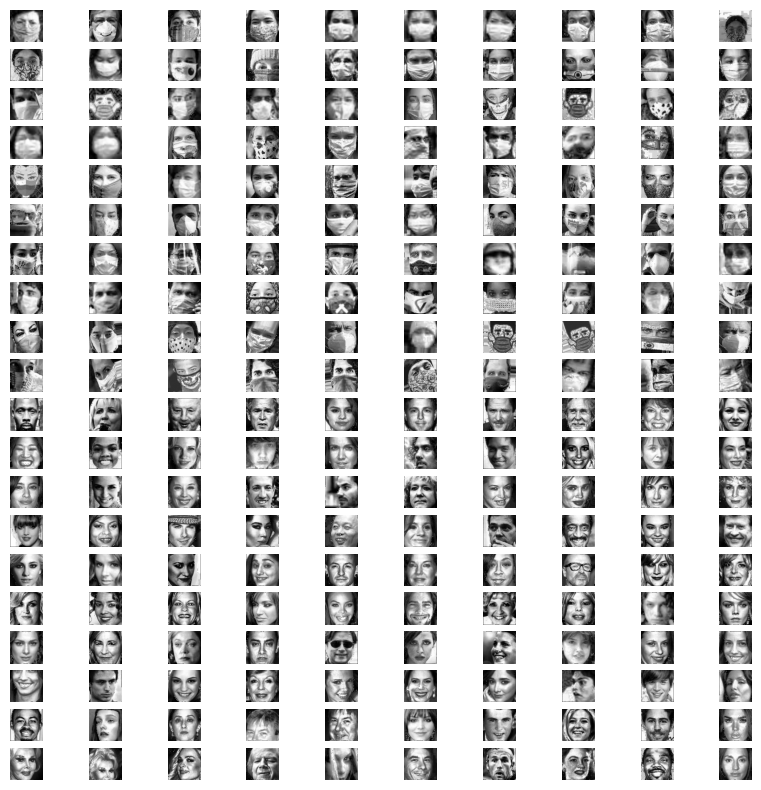

In [38]:
# pada bagian ini bisa gunakan data yang sebelum augmentasi atau setelah augmentasi
dataPreprocessed = []
for i in range(len(data)): # Loop through each image and do preprocessing
    img = equalize_histogram(data[i])
    img_proc = convolution(img, kernel)
    img_proc1 = medianfilter(img_proc, np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]]))
    img_proc2 = gaussian_blur(img_proc1)
    img_proc2 = img_proc2.astype(np.uint8)
    dataPreprocessed.append(img_proc2)

plt.figure(figsize=(10, 10))
for i in range(len(dataPreprocessed)):
    plt.subplot(20, 10, i + 1)
    plt.imshow(dataPreprocessed[i], cmap='gray')
    plt.axis('off')

plt.show()

1. Mengonversi data hasil preprocessing (`dataPreprocessed`), label (`labels`), dan nama file (`file_name`) menjadi array NumPy agar lebih mudah dalam pengolahan dan indexing.

2. Mengambil semua label unik yang ada di dataset menggunakan `np.unique(labels)` untuk mengetahui kategori atau kelas apa saja yang ada.

3. Untuk setiap label unik tersebut, kode akan:

   * Mengambil indeks 20 gambar pertama yang memiliki label tersebut.
   * Membuat sebuah figure besar untuk menampilkan gambar-gambar tersebut.
   * Menampilkan 20 gambar pertama dari label yang sedang diproses dalam susunan 2 baris dan 10 kolom.
   * Setiap gambar ditampilkan dalam skala abu-abu (`cmap='gray'`), dengan judul berupa nama file gambar tersebut.
   * Menghilangkan axis agar tampilan gambar lebih bersih.
   * Mengatur tata letak agar judul dan gambar tidak tumpang tindih.

4. Menampilkan plot setiap label secara terpisah sehingga mudah untuk memvisualisasikan contoh gambar dari setiap kategori secara sistematis.

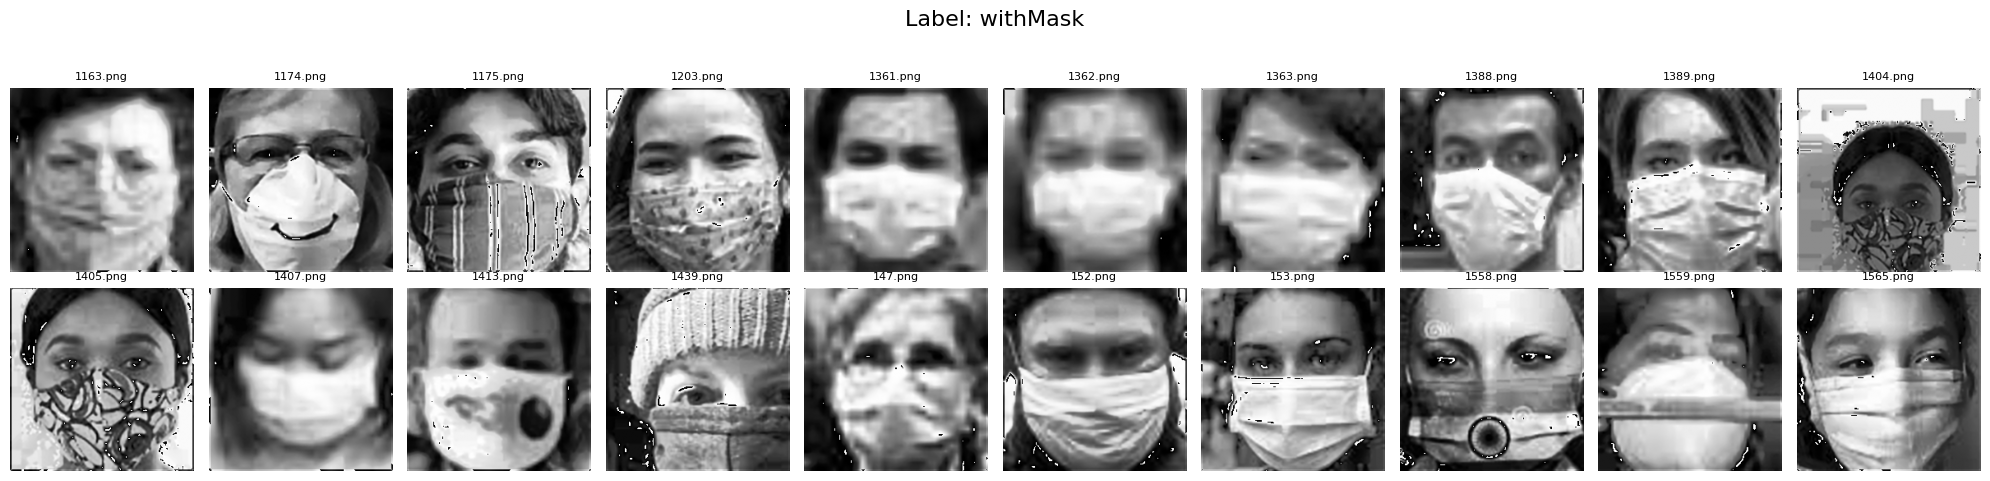

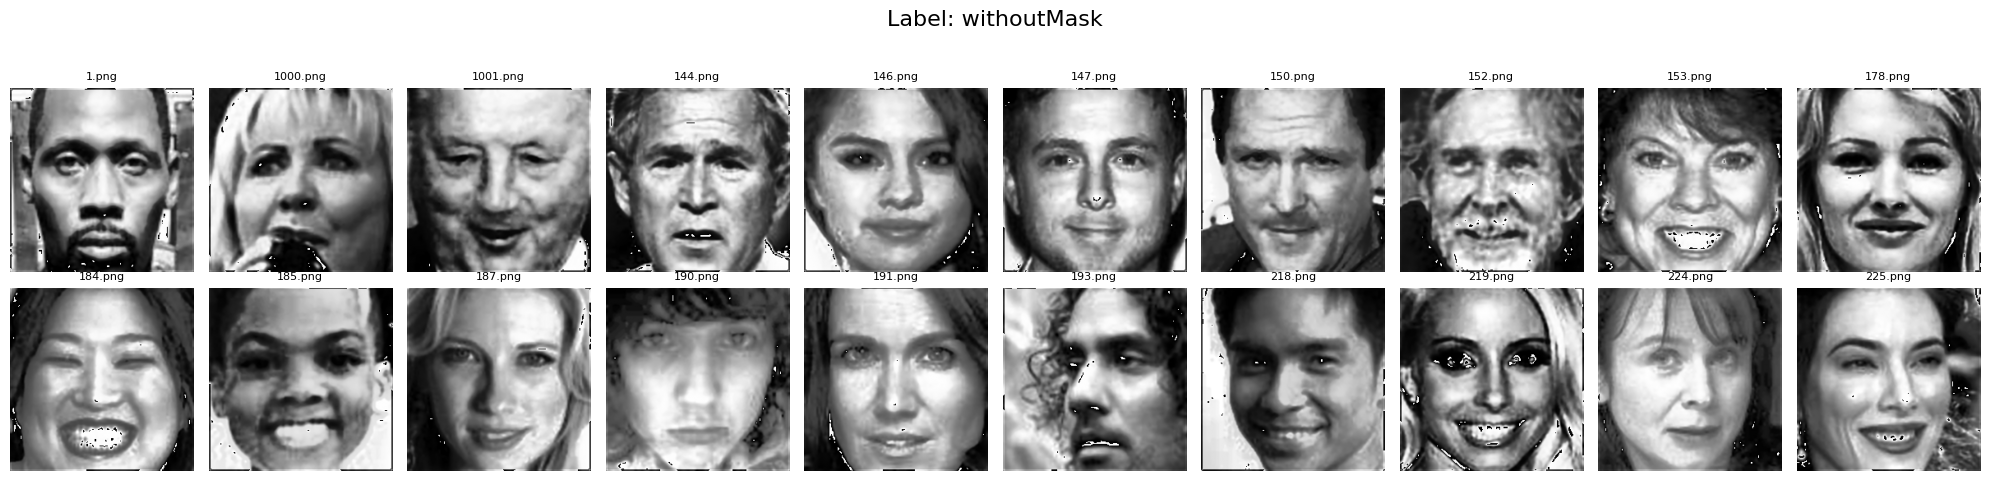

In [39]:
# Konversi ke array
dataPreprocessed = np.array(dataPreprocessed)
labels = np.array(labels)
file_name = np.array(file_name)

# Ambil semua label unik
unique_labels = np.unique(labels)

# Tampilkan 20 gambar pertama untuk setiap label
for label in unique_labels:
    # Ambil indeks yang cocok dengan label
    idx = np.where(labels == label)[0][:20]  # ambil 20 pertama saja
    
    # Ukuran figure
    plt.figure(figsize=(20, 5))
    plt.suptitle(f"Label: {label}", fontsize=16)

    for i, img_idx in enumerate(idx):
        plt.subplot(2, 10, i+1)
        plt.imshow(dataPreprocessed[img_idx], cmap='gray')
        plt.title(file_name[img_idx], fontsize=8)
        plt.axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

### Feature Extraction

* Membuat fungsi `glcm` yang menerima input berupa sebuah citra grayscale (`image`) dan sebuah sudut derajat (`derajat`).

* Berdasarkan nilai derajat (0, 45, 90, atau 135), fungsi mengkonversi derajat tersebut ke dalam radian yang sesuai, karena fungsi `graycomatrix` menggunakan radian untuk parameter sudut.

* Jika sudut derajat yang diberikan bukan salah satu dari 0, 45, 90, atau 135, fungsi akan menghasilkan error dengan pesan yang jelas.

* Fungsi kemudian memanggil `graycomatrix` dari pustaka skimage, dengan parameter:

  * jarak piksel 1,
  * sudut sesuai yang sudah diubah ke radian,
  * tingkat intensitas piksel 256 (citra 8-bit),
  * `symmetric=True` agar matriks GLCM simetris,
  * `normed=True` agar matriks GLCM ternormalisasi.

* Fungsi mengembalikan matriks GLCM yang dihasilkan, yaitu representasi statistik tekstur yang memperlihatkan seberapa sering kombinasi nilai intensitas piksel tertentu terjadi pada sudut dan jarak yang diberikan.

In [40]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

* Membuat fungsi `correlation` yang menerima input berupa sebuah matriks GLCM (`matriks`).

* Fungsi memanggil `graycoprops` dari pustaka skimage dengan parameter `'correlation'` untuk menghitung nilai fitur korelasi tekstur dari matriks GLCM tersebut.

* Karena `graycoprops` mengembalikan array 2D (karena GLCM bisa berisi lebih dari satu matriks untuk kombinasi sudut dan jarak), fungsi mengambil elemen `[0, 0]` untuk mengakses nilai korelasi pertama.

* Fungsi mengembalikan nilai korelasi tersebut sebagai output.

In [41]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

* Mendefinisikan fungsi `dissimilarity` yang menerima input berupa matriks GLCM (`matriks`).

* Fungsi memanggil `graycoprops` dengan argumen `'dissimilarity'` untuk menghitung fitur tekstur **dissimilarity** dari matriks GLCM tersebut.

* Mengakses elemen `[0, 0]` dari hasil yang dikembalikan `graycoprops`, karena outputnya berupa array 2D.

* Mengembalikan nilai dissimilarity tersebut sebagai hasil fungsi.

Jadi, kode ini digunakan untuk menghitung dan mengambil nilai fitur dissimilarity dari matriks GLCM yang merepresentasikan tekstur gambar.

In [42]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

* Mendefinisikan fungsi `homogenity` yang menerima input sebuah matriks GLCM (`matriks`).

* Menghitung fitur tekstur **homogeneity** (kadang juga disebut homogeneity atau inverse difference moment) menggunakan fungsi `graycoprops` dari pustaka scikit-image.

* Mengambil nilai pertama `[0, 0]` dari array hasil `graycoprops` karena hasilnya berbentuk matriks (karena parameter bisa lebih dari satu sudut).

* Mengembalikan nilai homogeneity tersebut sebagai output fungsi.

Dengan kata lain, fungsi ini digunakan untuk menghitung dan mendapatkan nilai homogenitas dari matriks GLCM sebagai salah satu fitur tekstur gambar.

In [43]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

* Mendefinisikan fungsi `contrast` yang menerima sebuah matriks GLCM (`matriks`) sebagai input.
* Menggunakan fungsi `graycoprops` dari pustaka scikit-image untuk menghitung fitur tekstur **contrast** (kontras) dari matriks GLCM tersebut.
* Mengambil elemen `[0, 0]` dari hasil `graycoprops` karena output berupa matriks, dan hanya nilai pertama yang dibutuhkan.
* Mengembalikan nilai kontras tersebut sebagai output fungsi.

Singkatnya, fungsi ini menghitung dan mengembalikan nilai fitur kontras dari matriks GLCM untuk analisis tekstur pada gambar.

In [44]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

Fungsi `ASM(matriks)` ini berfungsi untuk menghitung nilai Angular Second Moment (ASM) dari sebuah matriks GLCM (Gray Level Co-occurrence Matrix) menggunakan fungsi `graycoprops` dari pustaka skimage. Fungsi ini menerima matriks GLCM sebagai input dan mengembalikan nilai ASM yang merupakan ukuran konsentrasi atau homogenitas tekstur pada citra, diambil dari elemen pertama hasil `graycoprops` dengan properti 'ASM'. Nilai ASM yang tinggi menunjukkan tekstur yang lebih seragam dan teratur dalam gambar.

In [45]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

Fungsi `energy(matriks)` ini berfungsi untuk menghitung nilai energi tekstur dari sebuah matriks GLCM (Gray Level Co-occurrence Matrix) menggunakan fungsi `graycoprops` dari pustaka skimage. Fungsi ini menerima matriks GLCM sebagai input dan mengembalikan nilai energi yang merupakan akar kuadrat dari ASM (Angular Second Moment), yang mencerminkan tingkat homogenitas dan keteraturan tekstur pada citra. Nilai energi yang tinggi menunjukkan tekstur yang lebih seragam dan konsisten.

In [46]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

Fungsi `entropyGlcm(matriks)` ini berfungsi untuk menghitung entropi dari sebuah matriks GLCM (Gray Level Co-occurrence Matrix). Fungsi tersebut pertama-tama meratakan matriks GLCM menjadi sebuah vektor satu dimensi menggunakan `.ravel()`, kemudian menghitung entropi dari distribusi nilai-nilai tersebut dengan fungsi `entropy` dari pustaka scipy.stats. Entropi ini mengukur kompleksitas atau ketidakpastian tekstur pada citra, di mana nilai entropi yang lebih tinggi menunjukkan tekstur yang lebih kompleks dan acak.

In [47]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

Kode ini berfungsi untuk membuat empat list (`Derajat0`, `Derajat45`, `Derajat90`, dan `Derajat135`) yang masing-masing akan menyimpan matriks GLCM dari setiap citra pada `dataPreprocessed` dengan sudut (derajat) berbeda yaitu 0°, 45°, 90°, dan 135°. Pada setiap iterasi, fungsi `glcm()` dipanggil dengan citra yang sudah diproses dan sudut tertentu, lalu matriks GLCM hasilnya disimpan ke list yang sesuai dengan sudut tersebut. Dengan demikian, setiap citra akan memiliki empat matriks GLCM yang mewakili tekstur pada sudut-sudut berbeda, yang nantinya bisa digunakan untuk ekstraksi fitur tekstur.


In [48]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

Kode ini berfungsi untuk mendefinisikan sejumlah list kosong yang akan digunakan untuk menyimpan nilai-nilai fitur tekstur GLCM yang dihitung berdasarkan matriks GLCM pada empat arah sudut berbeda (0°, 45°, 90°, dan 135°). Setiap fitur tekstur (kontras, dissimilarity, homogenity, entropy, ASM, energy, dan korelasi) memiliki empat list yang terpisah untuk menampung nilai-nilai dari masing-masing arah sudut tersebut. Nantinya, list-list ini akan diisi dengan hasil ekstraksi fitur dari masing-masing matriks GLCM yang telah dibuat sebelumnya, sehingga memungkinkan analisis dan klasifikasi berbasis fitur tekstur dari berbagai orientasi citra.

In [49]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []


Kode ini berfungsi untuk melakukan perulangan sebanyak jumlah citra yang sudah dipreproses (`dataPreprocessed`). Pada setiap iterasi, kode ini mengambil matriks GLCM yang sudah dihitung untuk masing-masing sudut (0°, 45°, 90°, dan 135°) dari list `Derajat0`, `Derajat45`, `Derajat90`, dan `Derajat135`. Kemudian, fungsi `correlation()` dipanggil untuk menghitung nilai korelasi tekstur dari masing-masing matriks GLCM tersebut. Nilai korelasi hasil perhitungan tersebut kemudian disimpan ke dalam list `correlation0`, `correlation45`, `correlation90`, dan `correlation135` sesuai dengan sudutnya. Jadi, kode ini mengekstraksi fitur korelasi tekstur dari citra berdasarkan arah sudut yang berbeda.

In [50]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

Kode ini berfungsi untuk menghitung nilai fitur *contrast* (kontras) dari matriks GLCM untuk setiap citra dalam dataset `data`. Pada setiap iterasi, kode mengambil matriks GLCM dari masing-masing sudut (0°, 45°, 90°, dan 135°) yang sudah disimpan di list `Derajat0`, `Derajat45`, `Derajat90`, dan `Derajat135`. Kemudian, fungsi `contrast()` dipanggil untuk menghitung nilai kontras dari matriks GLCM tersebut. Hasil nilai kontras untuk setiap sudut disimpan masing-masing ke dalam list `Kontras0`, `Kontras45`, `Kontras90`, dan `Kontras135`. Dengan demikian, kode ini mengekstraksi fitur tekstur kontras dari setiap citra berdasarkan berbagai arah sudut.

In [51]:
for i in range(len(data)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

Kode ini berfungsi untuk menghitung nilai fitur *dissimilarity* (ketidaksamaan) dari matriks GLCM untuk setiap gambar dalam dataset `data`. Pada setiap iterasi, kode mengambil matriks GLCM dari empat arah sudut berbeda (0°, 45°, 90°, dan 135°) yang sudah disimpan di list `Derajat0`, `Derajat45`, `Derajat90`, dan `Derajat135`. Fungsi `dissimilarity()` kemudian digunakan untuk menghitung nilai ketidaksamaan dari masing-masing matriks GLCM tersebut. Nilai yang diperoleh dari setiap sudut disimpan secara terpisah di list `dissimilarity0`, `dissimilarity45`, `dissimilarity90`, dan `dissimilarity135`. Dengan demikian, kode ini mengekstraksi fitur tekstur dissimilarity dari setiap citra pada berbagai arah sudut.

In [52]:
for i in range(len(data)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

Kode ini berfungsi untuk menghitung nilai fitur *homogeneity* (kekerabatan atau kehalusan tekstur) dari matriks GLCM pada setiap gambar dalam dataset `data`. Pada setiap iterasi, kode mengambil matriks GLCM untuk empat sudut berbeda (0°, 45°, 90°, dan 135°) yang sudah tersimpan dalam list `Derajat0`, `Derajat45`, `Derajat90`, dan `Derajat135`. Fungsi `homogenity()` digunakan untuk mengekstraksi nilai homogenitas dari setiap matriks GLCM tersebut. Nilai-nilai homogenitas tersebut kemudian disimpan secara terpisah ke dalam list `homogenity0`, `homogenity45`, `homogenity90`, dan `homogenity135`. Dengan begitu, kode ini mengekstrak fitur homogenitas tekstur dari citra pada berbagai arah sudut.


In [53]:
for i in range(len(data)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

Kode ini berfungsi untuk menghitung nilai fitur *entropy* dari matriks GLCM untuk setiap gambar dalam dataset `data` pada empat sudut berbeda, yaitu 0°, 45°, 90°, dan 135°. Pada setiap iterasi, kode mengambil matriks GLCM yang sudah tersimpan di `Derajat0`, `Derajat45`, `Derajat90`, dan `Derajat135`, lalu menggunakan fungsi `entropyGlcm()` untuk menghitung *entropy* dari setiap matriks tersebut. Nilai entropy yang didapat kemudian disimpan dalam list `entropy0`, `entropy45`, `entropy90`, dan `entropy135`. Entropy ini menggambarkan tingkat keragaman atau kompleksitas tekstur dalam gambar pada masing-masing arah sudut.


In [54]:
for i in range(len(data)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

Kode ini berfungsi untuk menghitung nilai **ASM (Angular Second Moment)** atau juga dikenal sebagai **Uniformity** dari matriks GLCM untuk setiap gambar pada sudut 0°, 45°, 90°, dan 135°. Pada setiap iterasi, kode mengambil matriks GLCM dari `Derajat0`, `Derajat45`, `Derajat90`, dan `Derajat135`, lalu menghitung nilai ASM menggunakan fungsi `ASM()`. Nilai hasil perhitungan kemudian disimpan dalam list `ASM0`, `ASM45`, `ASM90`, dan `ASM135`. ASM ini merepresentasikan tingkat kehomogenan tekstur dalam gambar—semakin tinggi nilai ASM, semakin seragam atau homogen tekstur gambar tersebut.


In [55]:
for i in range(len(data)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

Kode ini berfungsi untuk menghitung nilai **Energy** dari matriks GLCM untuk setiap gambar pada empat sudut arah (0°, 45°, 90°, dan 135°). Dalam setiap iterasi, kode mengambil matriks GLCM dari masing-masing sudut (yang telah dihitung sebelumnya), kemudian memanggil fungsi `energy()` untuk mendapatkan nilai energi dari tekstur tersebut. Hasilnya kemudian disimpan ke dalam list `energy0`, `energy45`, `energy90`, dan `energy135`. Nilai **Energy** mencerminkan tingkat kehomogenan suatu citra — nilai yang tinggi menunjukkan tekstur yang seragam dan berulang, sedangkan nilai rendah menunjukkan tekstur yang kompleks atau acak.


In [56]:
for i in range(len(data)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

### Write the extraction's results to CSV 

Kode ini berfungsi untuk menyusun dan menyimpan hasil ekstraksi fitur tekstur dari citra ke dalam sebuah file CSV. Setiap gambar diwakili oleh nama file (`Filename`) dan labelnya (`Label`), serta nilai-nilai dari fitur tekstur seperti Contrast, Homogeneity, Dissimilarity, Entropy, ASM, Energy, dan Correlation yang dihitung menggunakan matriks GLCM pada empat arah sudut (0°, 45°, 90°, dan 135°). Seluruh data disusun dalam bentuk dictionary, kemudian dikonversi menjadi DataFrame menggunakan pustaka `pandas`, dan disimpan ke dalam file bernama `hasil_ekstraksi_1.csv`. File ini kemudian dibaca kembali untuk memastikan data telah tersimpan dengan benar dan siap digunakan untuk analisis atau pelatihan model klasifikasi.


In [57]:
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_1.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_1.csv')
hasilEkstrak


,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,1163.png,withMask,66.515915,109.189769,64.540659,108.173420,0.339748,0.257972,0.338945,0.245579,...,0.000431,0.000285,0.020513,0.017384,0.020769,0.016889,0.993863,0.989899,0.994034,0.989993
1,1174.png,withMask,260.911155,427.943212,309.794783,437.818255,0.330885,0.248467,0.332503,0.259092,...,0.000396,0.000289,0.020248,0.016824,0.019894,0.016988,0.976701,0.961827,0.972442,0.960947
2,1175.png,withMask,1444.513313,1567.271934,449.742353,1612.439603,0.221416,0.165964,0.264110,0.167864,...,0.000284,0.000156,0.014483,0.012473,0.016846,0.012508,0.869664,0.858432,0.959461,0.854354
3,1203.png,withMask,252.268378,471.281003,301.109625,404.735486,0.257703,0.172889,0.226972,0.177738,...,0.000254,0.000188,0.016753,0.013501,0.015948,0.013717,0.976828,0.956718,0.972403,0.962829
4,1361.png,withMask,21.382667,52.626295,31.027226,51.351204,0.393421,0.279576,0.367991,0.274538,...,0.000471,0.000322,0.023055,0.018090,0.021703,0.017939,0.998041,0.995180,0.997155,0.995297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,967.png,withoutMask,110.301830,259.423093,201.853780,255.210843,0.304733,0.264459,0.350536,0.250520,...,0.002793,0.002321,0.049647,0.048674,0.052853,0.048173,0.989578,0.975472,0.980923,0.975870
196,972.png,withoutMask,667.732423,949.967162,563.482864,934.285588,0.208185,0.152080,0.210402,0.151137,...,0.000232,0.000162,0.015073,0.012620,0.015221,0.012730,0.940757,0.915599,0.949964,0.916995
197,973.png,withoutMask,514.659253,715.552635,423.988969,718.012970,0.223770,0.170013,0.225870,0.167084,...,0.000247,0.000174,0.015455,0.013146,0.015709,0.013204,0.953894,0.935876,0.962025,0.935656
198,998.png,withoutMask,998.540859,1438.761085,979.680293,1424.742967,0.211694,0.169631,0.228768,0.164593,...,0.000398,0.000286,0.018929,0.017067,0.019943,0.016917,0.914767,0.876994,0.916581,0.878192


### Features Selection

pada bagian seleksi fitur ini bisa menggunakan metode seperti
- PCA
- LDA
- t-SNE
- Chi-square
- ANOVA
- Autoencoder
- correlation
- dll

berikut contoh menggunakan correlation:

Kode ini berfungsi untuk melakukan seleksi fitur berdasarkan korelasi antar fitur dalam dataset hasil ekstraksi citra. Pertama, kode menghitung matriks korelasi dari seluruh fitur numerik (dengan menghapus kolom `Label` dan `Filename`). Kemudian, fitur-fitur yang memiliki korelasi tinggi satu sama lain (absolut ≥ 0.95) dianggap redundant atau saling berlebihan, sehingga hanya salah satunya yang dipertahankan. Proses ini dilakukan dengan menggunakan logika boolean array `columns` untuk menyaring fitur-fitur yang tetap digunakan. Setelah seleksi, fitur yang lolos disimpan dalam variabel `x_new`, sementara `y` berisi label sebagai target klasifikasi. Terakhir, visualisasi korelasi antar fitur yang telah terseleksi ditampilkan dalam bentuk *heatmap* menggunakan `seaborn`, untuk memberikan gambaran seberapa kuat hubungan antar fitur yang dipertahankan.


<Axes: >

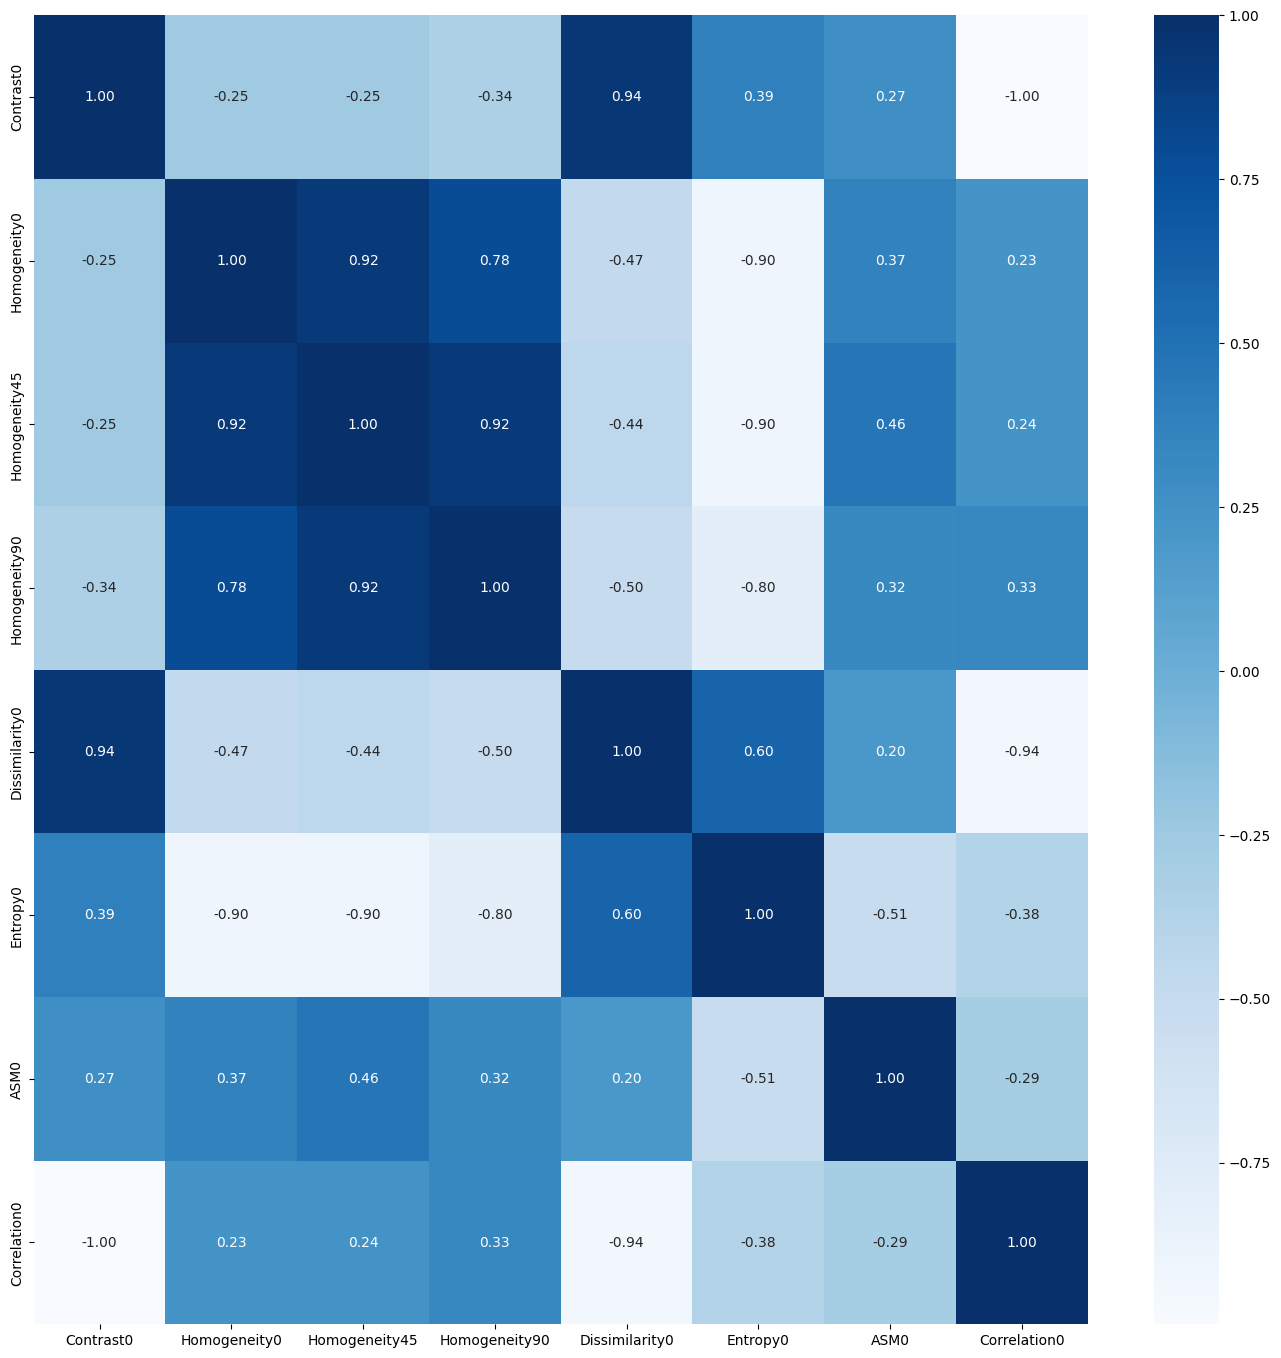

In [58]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

## Splitting Data

Kode ini berfungsi untuk membagi data fitur (`x_new`) dan label (`y`) ke dalam dua set: data pelatihan (*training*) dan data pengujian (*testing*). Parameter `test_size=0.2` berarti 20% data digunakan untuk pengujian, dan sisanya 80% untuk pelatihan. Fungsi `train_test_split` dari `sklearn.model_selection` digunakan untuk proses ini dengan `random_state=42` agar pembagian data bersifat konsisten dan dapat direproduksi. Setelah pembagian, ukuran masing-masing set ditampilkan dengan `print`, yang menunjukkan jumlah sampel dan fitur dalam `X_train` dan `X_test`.


In [59]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(160, 8)
(40, 8)


## Feature Normalization

berikut metode normalisasi yang bisa digunakan:
- Min-Max Scaling
- Standardization (Z-score)
- Robust Scaling
- MaxAbsScaler
- dll

berikut contoh menggunakan Standardization (Z-score):

* **Tujuannya**: Membuat fitur pada data training dan testing memiliki rata-rata (`mean`) 0 dan standar deviasi (`std`) 1, sehingga model machine learning tidak terpengaruh oleh skala fitur yang berbeda-beda.

* **Cara kerjanya**:
  Setiap nilai pada `X_train` dan `X_test` dikurangi dengan rata-rata fitur pada data training (`X_train.mean()`), lalu dibagi dengan standar deviasi fitur pada data training (`X_train.std()`).

* **Catatan penting**:
  Normalisasi `X_test` menggunakan statistik (mean dan std) dari `X_train` agar model tidak mendapatkan informasi dari data testing selama training, menjaga generalisasi yang baik.

In [60]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

## Modeling

### Define Model

* **`generateClassificationReport(y_true, y_pred)`**:
  Fungsi ini menerima label asli (`y_true`) dan label prediksi (`y_pred`), lalu menampilkan:

  * Classification report yang berisi metrik seperti precision, recall, f1-score untuk setiap kelas.
  * Confusion matrix yang menunjukkan distribusi prediksi benar dan salah per kelas.
  * Akurasi keseluruhan model.

* Mendefinisikan tiga model klasifikasi yang akan digunakan:

  * **Random Forest Classifier (`rf`)** dengan 5 pohon keputusan dan `random_state=42` agar hasil bisa direproduksi.
  * **Support Vector Machine (`svm`)** dengan kernel radial basis function (RBF) dan `random_state=42`.
  * **K-Nearest Neighbors (`knn`)** dengan jumlah tetangga terdekat sebanyak 5.

Kode ini mempersiapkan fungsi evaluasi dan tiga algoritma klasifikasi yang akan digunakan untuk pelatihan dan pengujian selanjutnya.

In [61]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

### Train Random Forest Classifier

* Melatih model **Random Forest Classifier** menggunakan data training (`X_train` dan `y_train`) dengan memanggil `rf.fit()`.
* Setelah model selesai dilatih, melakukan prediksi label pada data training menggunakan `rf.predict(X_train)`.
* Menampilkan laporan evaluasi performa model pada data training dengan memanggil fungsi `generateClassificationReport`, yang mencakup classification report, confusion matrix, dan akurasi.
* Melakukan prediksi label pada data testing (`X_test`).
* Menampilkan laporan evaluasi performa model pada data testing menggunakan fungsi yang sama.

kode ini digunakan untuk melatih dan mengukur kinerja model Random Forest pada data training dan data testing agar dapat menilai kemampuan model dalam mempelajari data dan melakukan generalisasi.


In [62]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
              precision    recall  f1-score   support

    withMask       0.95      0.97      0.96        79
 withoutMask       0.97      0.95      0.96        81

    accuracy                           0.96       160
   macro avg       0.96      0.96      0.96       160
weighted avg       0.96      0.96      0.96       160

[[77  2]
 [ 4 77]]
Accuracy: 0.9625

------Testing Set------
              precision    recall  f1-score   support

    withMask       0.83      0.95      0.89        21
 withoutMask       0.94      0.79      0.86        19

    accuracy                           0.88        40
   macro avg       0.89      0.87      0.87        40
weighted avg       0.88      0.88      0.87        40

[[20  1]
 [ 4 15]]
Accuracy: 0.875


### Train SVM Classifier

* Melatih model Support Vector Machine (SVM) dengan kernel RBF menggunakan data training (`X_train` dan `y_train`) melalui `svm.fit()`.
* Setelah model selesai dilatih, melakukan prediksi label pada data training dengan `svm.predict(X_train)`.
* Mencetak laporan performa model pada data training menggunakan fungsi `generateClassificationReport`, yang mencakup classification report, confusion matrix, dan akurasi.
* Kemudian, melakukan prediksi label pada data testing (`X_test`).
* Mencetak laporan evaluasi performa model pada data testing dengan fungsi yang sama.

kode ini menjalankan proses pelatihan dan evaluasi model SVM pada data training dan testing untuk melihat seberapa baik model mempelajari pola dan mampu menggeneralisasi data baru.

In [63]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

    withMask       0.90      0.84      0.87        79
 withoutMask       0.85      0.91      0.88        81

    accuracy                           0.88       160
   macro avg       0.88      0.87      0.87       160
weighted avg       0.88      0.88      0.87       160

[[66 13]
 [ 7 74]]
Accuracy: 0.875

------Testing Set------
              precision    recall  f1-score   support

    withMask       0.88      1.00      0.93        21
 withoutMask       1.00      0.84      0.91        19

    accuracy                           0.93        40
   macro avg       0.94      0.92      0.92        40
weighted avg       0.93      0.93      0.92        40

[[21  0]
 [ 3 16]]
Accuracy: 0.925


### Train KNN Classifier

* Melatih model K-Nearest Neighbors (KNN) menggunakan data training (`X_train` dan `y_train`) dengan `knn.fit()`.
* Setelah model dilatih, melakukan prediksi label pada data training dengan `knn.predict(X_train)`.
* Mencetak laporan evaluasi performa model pada data training menggunakan fungsi `generateClassificationReport`, yang menampilkan classification report, confusion matrix, dan akurasi.
* Selanjutnya, melakukan prediksi label pada data testing (`X_test`).
* Mencetak laporan evaluasi performa model pada data testing menggunakan fungsi yang sama.

kode ini mengevaluasi performa KNN pada kedua dataset: training dan testing, untuk melihat bagaimana model belajar dan bagaimana kemampuannya menggeneralisasi ke data baru.


In [64]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)



------Training Set------
              precision    recall  f1-score   support

    withMask       0.91      0.85      0.88        79
 withoutMask       0.86      0.91      0.89        81

    accuracy                           0.88       160
   macro avg       0.88      0.88      0.88       160
weighted avg       0.88      0.88      0.88       160

[[67 12]
 [ 7 74]]
Accuracy: 0.88125

------Testing Set------
              precision    recall  f1-score   support

    withMask       0.83      0.95      0.89        21
 withoutMask       0.94      0.79      0.86        19

    accuracy                           0.88        40
   macro avg       0.89      0.87      0.87        40
weighted avg       0.88      0.88      0.87        40

[[20  1]
 [ 4 15]]
Accuracy: 0.875


## Evaluation With Confusion Matrix

* Mendefinisikan fungsi `plot_confusion_matrix` yang menerima tiga parameter: `y_true` (label asli), `y_pred` (label prediksi), dan `title` (judul grafik).
* Menghitung matriks kebingungan (confusion matrix) antara `y_true` dan `y_pred` menggunakan fungsi `confusion_matrix`.
* Membuat objek `ConfusionMatrixDisplay` untuk visualisasi matriks kebingungan tersebut.
* Menampilkan matriks kebingungan dengan colormap warna biru (`Blues`) agar lebih mudah dibaca.
* Menambahkan judul pada plot sesuai parameter `title`.
* Menampilkan plot matriks kebingungan.

Selanjutnya, fungsi ini digunakan untuk menampilkan matriks kebingungan hasil prediksi dari tiga model klasifikasi berbeda: Random Forest, SVM, dan KNN, masing-masing pada data testing (`X_test`). Hal ini membantu dalam mengevaluasi performa model dengan visual yang mudah dipahami.

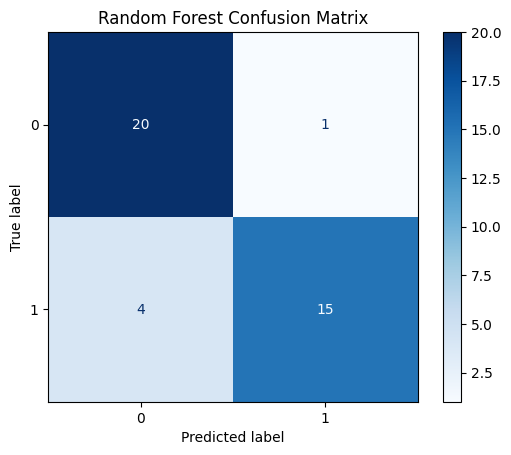

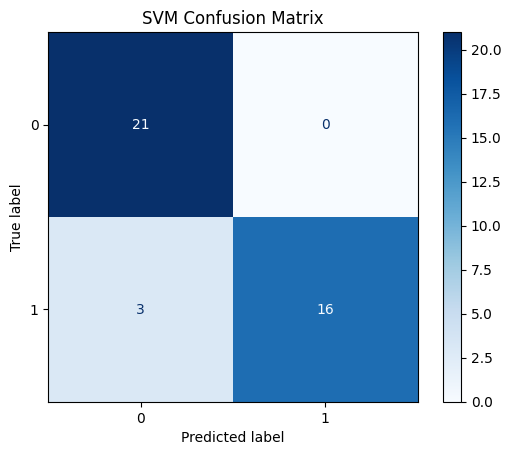

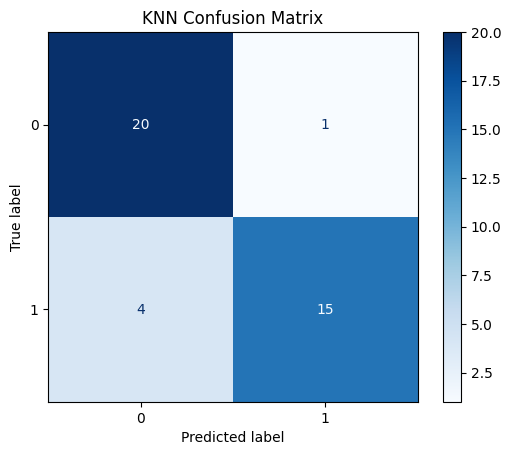

In [65]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")